In [2]:
import numpy as np
from scipy import stats, linalg
from folktables import ACSDataSource, ACSMobility
from matplotlib import pyplot as plt
import torch

In [6]:
def m_dist2(x1, x2, K):
    return (x2 - x1).T @ K @ (x2 - x1)

def generate_synthetic_data(n, r, p, data):
    X = data.sample(n, axis=0)
    X = X.loc[:, X.var(axis=0) > 0]
    X = X.sample(p, axis=1)
    X = stats.zscore(np.array(X), axis=0)
   
    Astar = np.random.normal(0, 1, size=(p, r)) / np.math.sqrt(p)
    Kstar = Astar @ Astar.T
    
    Sbar = []
    for i in range(n):
        for j in range(n):
            for k in range(n):
                if i != j and j != k and k != i:
                    Sbar.append((i, j, k))
    Sbar = np.array(Sbar)
    
    choices = np.random.choice([False, True], p=[0.9, 0.1], size=len(Sbar))
    S = Sbar[choices, :]
    
    y = []
    for t in S:
        i, j, k = t
        prob = 1 / (1 + np.math.exp(m_dist2(X[i], X[k], Kstar) - m_dist2(X[i], X[j], Kstar)))
        yt = np.random.choice([1, -1], p=[prob, 1 - prob])
        y.append(yt)
    y = np.array(y)
    
    return X, S, y, Astar, Kstar

def initialization(n, p, S, y):
    transition_matrices = [np.zeros((n - 1, n - 1)) for _ in range(n)]
    for t in range(len(S)):
        def gap(l, i):
            if l < i:
                return l
            else:
                return l - 1
        i, j, k = S[t]
        transition_matrices[i][gap(j, i), gap(k, i)] = 0.9 if y[t] == 1 else 0.1
        transition_matrices[i][gap(k, i), gap(j, i)] = 0.9 if y[t] == -1 else 0.1

    for i in range(n):
        d = np.max(np.sum(transition_matrices[i], axis=1))
        transition_matrices[i] = transition_matrices[i] / d

        self_loops = np.diag(1 - np.sum(transition_matrices[i], axis=1))

        transition_matrices[i] += self_loops

    dists_from_i = []
    for i in range(n):
        eigenvalues, eigenvectors = linalg.eig(transition_matrices[i], left=True, right=False)
        leading_index = np.where(np.isclose(eigenvalues, 1))[0]
        leading_eigenvector = np.abs(eigenvectors[:, leading_index].real)
        dists_wo_i = np.log(leading_eigenvector)
        if not np.all(np.isfinite(dists_wo_i)):
            print(i)
        dists = np.insert(dists_wo_i, i, 0)
        dists_from_i.append(dists)
    D = np.stack(dists_from_i)
    Dtilde = D + D.T / 2
    
    J = np.identity(n) - (np.ones((n, 1)) @ np.ones((1, n))) / n
    H = - J @ Dtilde @ J / 2
    
    XtHX = X.T @ H @ X
    Sigma = X.T @ X
    eigenvalues, eigenvectors = linalg.eig(a=XtHX, b=Sigma)
    U = eigenvectors[:, np.argsort(eigenvalues)[-r:]]
    Lambda = np.sort(eigenvalues)[-r:]
    AAt = U @ np.diag(Lambda) @ U.T
    
    V, s, W = linalg.svd(AAt)
    
    top_r_indicies = np.argsort(s)[:r]
    V_r = V[:, top_r_indicies].reshape((p, r))
    s_r = s[top_r_indicies]
    Ahat = V_r @ np.sqrt(np.diag(s_r))

    return Ahat

def L(A):
    triplets = torch.tensor(signed_M, requires_grad=True, device="cuda")
    
    yMtAs = torch.einsum('bij,jk->bik', triplets, A)
    yMtAATs = torch.einsum('bij,jk->bik', yMtAs, torch.transpose(A, 0, 1))
    TryMtAATs = torch.einsum('bii->b', yMtAATs)
    losses = torch.log(1 + torch.exp(-TryMtAATs))
    
    return torch.mean(losses)

In [4]:
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["AL"], download=True)

acs_data_cleaned = acs_data.select_dtypes(include="float64")
acs_data_cleaned = acs_data_cleaned.loc[:, ~(acs_data_cleaned.isna().mean(axis=0) > 0.78)]
acs_data_cleaned = acs_data_cleaned.loc[~acs_data_cleaned.isna().any(axis=1)]
acs_data_cleaned = acs_data_cleaned.loc[:, (acs_data_cleaned.var(axis=0) > 0)]
print(np.shape(np.array(acs_data_cleaned)))

r = 3
p = 20
n = 150

print("Generating synthetic data...")   
X, S, y, Astar, Kstar = generate_synthetic_data(n, r, p, acs_data_cleaned)

np.save("Astar.npy", Astar)

print("Initializing...")
A0 = initialization(n, p, S, y)

M = []
for t in S:
    i, j, k = t
    Mt = np.outer(X[i], X[k]) + np.outer(X[k], X[i]) - np.outer(X[i], X[j]) - np.outer(X[j], X[i]) + np.outer(X[j], X[j]) - np.outer(X[k], X[k])
    M.append(Mt)
M = np.array(M)

signed_M = np.multiply(M, np.reshape(y, (-1, 1, 1)))

(544, 46)
Generating synthetic data...


/tmp/ipykernel_241266/584244010.py:10: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  Astar = np.random.normal(0, 1, size=(p, r)) / np.math.sqrt(p)
/tmp/ipykernel_241266/584244010.py:27: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  prob = 1 / (1 + np.math.exp(m_dist2(X[i], X[k], Kstar) - m_dist2(X[i], X[j], Kstar)))


Initializing...


Starting gradient descent...
10 tensor(0.6931, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>) 1.372176709409401
20 tensor(0.6931, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>) 1.372176709409401
30 tensor(0.6931, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>) 1.372176709409401
40 tensor(0.6931, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>) 1.372176709409401
50 tensor(0.6931, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>) 1.372176709409401
60 tensor(0.6931, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>) 1.372176709409401
70 tensor(0.6931, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>) 1.372176709409401
80 tensor(0.6931, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>) 1.372176709409401
90 tensor(0.6931, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>) 1.372176709409401
100 tensor(0.6931, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>

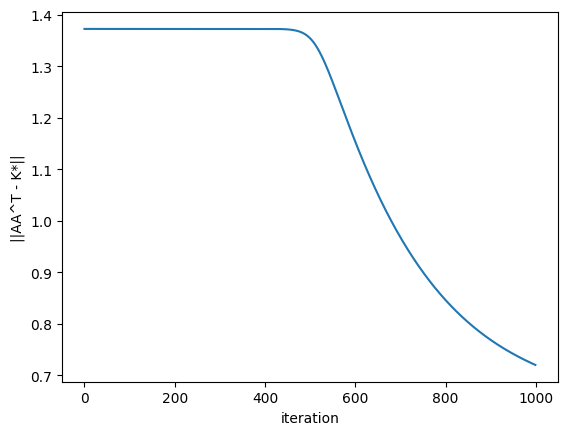

In [9]:
print("Starting gradient descent...")

A_iterates = []
A = torch.tensor(A0.real, requires_grad=True, device="cuda")
dists = []

for iterate in range(1000):
    loss = L(A)
    loss.backward()
    with torch.no_grad():
        A -= A.grad * 0.01
        A_iterates.append(A.detach().cpu().numpy())
        dists.append(np.linalg.norm(A.detach().cpu().numpy() @ A.detach().cpu().numpy().T - Kstar))
        A.grad.zero_()
    if iterate % 10 == 9:
        print(iterate + 1, loss, np.linalg.norm(A.detach().cpu().numpy() @ A.detach().cpu().numpy().T - Kstar))

np.save("A_iterates.npy", A_iterates)

plt.plot(dists)
plt.xlabel("iteration")
plt.ylabel("||AA^T - K*||")

plt.savefig("gd.png")